# OONI Data Analysis - Preliminary Exploration

In [2]:
# Imports
from matplotlib import pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import os
from urllib.parse import urlparse

In [3]:
# Plot configuration
seaborn.set_style('dark')

## (1) Data Cleaning
In this step we load and clean up the pre-procsesed data in order to get it into a form that can be analyzed.

In [4]:
# Load the pre-processed data and set up the index based on date
data_dir = '../results/ZW/processed/2022/'
web_connectivity = pd.read_csv(os.path.join(data_dir, 'webconnectivity.csv'))
web_connectivity['date'] = pd.to_datetime(web_connectivity['date'])
web_connectivity = web_connectivity.set_index('date')
web_connectivity

,probe_asn,control_failure,x_null_null_flags,status_code_match,title_match,blocking,resolver_asn,accessible,headers_match,input,body_proportion,dns_experiment_failure,x_dns_flags,http_experiment_failure,body_length_match,dns_consistency,x_blocking_flags
date,,,,,,,,,,,,,,,,,
2022-01-01,AS37204,NaN,NaN,True,True,False,AS37204,True,True,http://www.ask.com/,1.000000,NaN,NaN,NaN,True,consistent,NaN
2022-01-01,AS37204,NaN,NaN,True,NaN,False,AS37204,True,True,http://www.aidsonline.com/,0.000000,NaN,NaN,NaN,NaN,consistent,NaN
2022-01-01,AS37204,NaN,NaN,True,False,False,AS37204,True,True,http://craigslist.org/,0.973510,NaN,NaN,NaN,True,consistent,NaN
2022-01-01,AS37204,NaN,NaN,True,True,False,AS37204,True,True,https://mstdn.jp/,0.999948,NaN,NaN,NaN,True,consistent,NaN
2022-01-01,AS37204,NaN,NaN,True,NaN,False,AS37204,True,True,https://gmail.com/,0.000000,NaN,NaN,NaN,NaN,consistent,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS37204,connection_reset,NaN,NaN,NaN,NaN,AS37204,NaN,NaN,http://www.hackhull.com/,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31,AS37204,NaN,NaN,True,True,False,AS37204,True,True,http://www.hacktivismo.com/,1.000000,NaN,NaN,NaN,True,consistent,NaN
2022-12-31,AS37204,NaN,NaN,True,True,False,AS37204,True,True,https://www.hammerandtongues.com/,1.000000,NaN,NaN,NaN,True,consistent,NaN


In [5]:
# Standardize URLs
def url_standardize(url):
    p = urlparse(url)
    b = p.netloc.split('.')
    c = '.'.join(b[len(b)-2:])  # Remove any www
    return c+p.path
    
web_connectivity['input'] = web_connectivity['input'].map(url_standardize)

In [6]:
# Filter data into specific blocking methods
dns_events = web_connectivity[web_connectivity['blocking'] == 'dns']
httpdiff_events = web_connectivity[web_connectivity['blocking'] == 'http-diff']
httpfail_events = web_connectivity[web_connectivity['blocking'] == 'http-failure']
tcp_events = web_connectivity[web_connectivity['blocking'] == 'tcp_ip']
web_connectivity['blocking'].unique()

array(['False', nan, 'tcp_ip', 'http-diff', 'dns', 'http-failure'],
      dtype=object)

## (2) Data Exploration

In [7]:
# Compute rolling totals
k=7
total_events = web_connectivity.groupby(web_connectivity.index).size().rolling(window=k).sum().dropna()
total_dns = dns_events.groupby(dns_events.index).size().rolling(window=k).sum().dropna()
total_httpdiff = httpdiff_events.groupby(httpdiff_events.index).size().rolling(window=k).sum().dropna()
total_httpfail = httpfail_events.groupby(httpfail_events.index).size().rolling(window=k).sum().dropna()
total_tcp = tcp_events.groupby(tcp_events.index).size().rolling(window=k).sum().dropna()

In [8]:
# Compute fractional events
frac_dns = total_dns/total_events
frac_httpdiff = total_httpdiff/total_events
frac_httpfail = total_httpfail/total_events
frac_tcp = total_tcp/total_events
frac_dns = frac_dns.fillna(0)
frac_httpdiff = frac_httpdiff.fillna(0)
frac_httpfail = frac_httpfail.fillna(0)
frac_tcp = frac_tcp.fillna(0)

Text(0.5, 1.0, 'Fractional Blocking Events Over Time (k=7)')

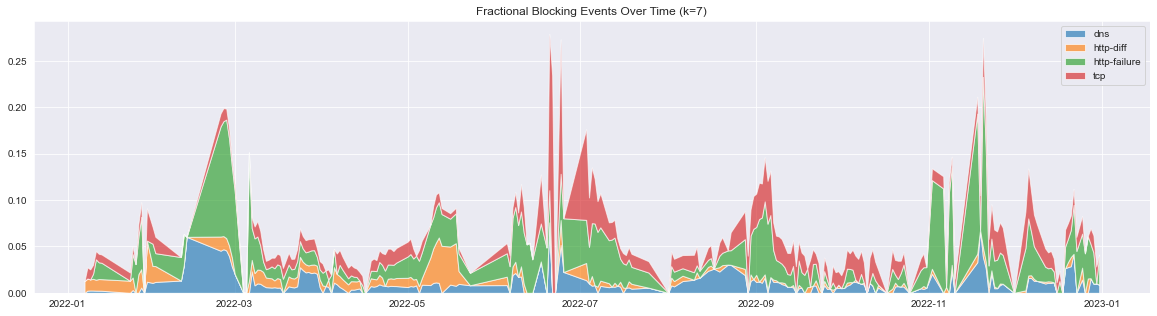

In [9]:
# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(total_events.index, frac_dns, frac_httpdiff, frac_httpfail, frac_tcp, labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events Over Time (k={k})')

Text(0.5, 1.0, 'Fractional Blocking Events From 2022-02-16-2022-03-23 (k=7)')

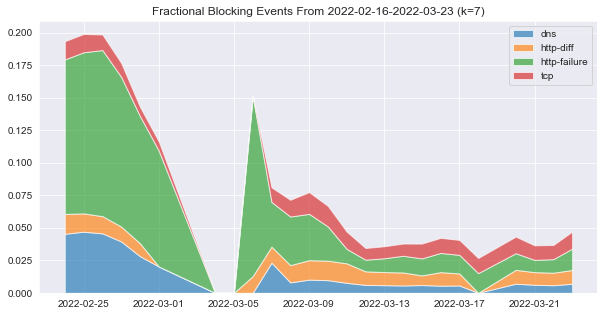

In [28]:
# Zoom in on a region of interest
start_date = '2022-02-16'
end_date = '2022-03-23'
filter_range = total_events.index[(total_events.index >= start_date) & (total_events.index <= end_date)]
plt.rcParams['figure.figsize'] = [10, 5]
plt.stackplot(filter_range, frac_dns[filter_range], frac_httpdiff[filter_range], frac_httpfail[filter_range], frac_tcp[filter_range], labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events From {start_date}-{end_date} (k={k})')

In [11]:
# Get blocking events in small date range
filter_tcp_range = (tcp_events.index >= start_date) & (tcp_events.index <= end_date)
filter_total_range = (web_connectivity.index >= start_date) & (web_connectivity.index <= end_date)
tcp_during = tcp_events[filter_tcp_range].groupby('input').size()
total_during = web_connectivity[filter_total_range].groupby('input').size()
frac_tcp_during = (tcp_during/total_during).fillna(0)
tcp_during.sort_values(ascending=False)
#print((tcp_during/total_during.sum()).sort_values(ascending=False)[:20])
tcp_out = tcp_events[~filter_tcp_range].groupby('input').size()
total_out = web_connectivity[~filter_total_range].groupby('input').size()
frac_tcp_out = (tcp_out/total_out).fillna(0)
#print((tcp_out/total_out.sum()).sort_values(ascending=False)[:20])
diff_frac_tcp = (frac_tcp_during-frac_tcp_out).sort_values(ascending=False).dropna()
diff_frac_tcp[:30]

input
efonica.com/                      1.000000
icftu.org/                        1.000000
lingeriebowl.com/                 1.000000
blubster.com/                     1.000000
webspawner.com/                   1.000000
friendster.com/                   0.857143
proxpn.com/                       0.614583
protectionline.org/               0.500000
searx.me/                         0.500000
imqq.com/                         0.486301
yubo.live/                        0.481818
altpenis.com/                     0.428571
pinboard.in/                      0.374359
maven.org/                        0.333333
livejournal.com/anorexicqueen/    0.333333
sakhr.com/                        0.250000
thezimbabwemail.com/              0.250000
4online-gambling.com/             0.250000
thehiddenwiki.org/                0.250000
warchild.org/                     0.250000
capitalkfm.com/                   0.222222
dailymotion.com/                  0.222222
zimsentinel.com/                  0.222222
attri

In [12]:
from statsmodels.stats.proportion import proportions_ztest

blocking_start = "2022-03-24"
blocking_end = "2022-04-18"

inner_range = (web_connectivity.index >= start_date) & (web_connectivity.index <= end_date)
outer_range = (web_connectivity.index < start_date) | (web_connectivity.index > end_date)
tcp_during = web_connectivity[inner_range].groupby('blocking').size()
tcp_outside = web_connectivity[outer_range].groupby('blocking').size()

successes = [tcp_during.sum() - tcp_during["False"], tcp_outside.sum() - tcp_outside["False"]]
sample_sizes = [tcp_during.sum(), tcp_outside.sum()]
print(successes)
print(sample_sizes)
z_stat, p_value = proportions_ztest(successes, sample_sizes)
print(f"Z-Statistic: {z_stat}")
print(f"P-Value: {p_value}")
print(successes[0] / sample_sizes[0])
print(successes[1] / sample_sizes[1])

[1129, 5954]
[12726, 110114]
Z-Statistic: 15.874230357789642
P-Value: 9.557607055346751e-57
0.08871601445858872
0.05407123526527054


In [13]:
import scipy.stats as stats

# Chi-square test of independence of variables
grouped_frame = pd.DataFrame({
    "during": tcp_during,
    "outside": tcp_outside
})
chi2, p_value, dof, expected = stats.chi2_contingency(grouped_frame.T)  # .T to transpose and get the correct format

# Step 3: Output the results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic: 390.4882996333485
P-value: 3.1574743389624898e-83


In [14]:
tcp_blocked = tcp_events[filter_tcp_range].groupby('input').size()
print(len(tcp_blocked))
for i, j in tcp_during.items():
    print(str(i) + " " + str(j))

180
False 11597
dns 128
http-diff 232
http-failure 515
tcp_ip 254


Text(0.5, 1.0, 'Fractional Blocking Events Over Time (k=7)')

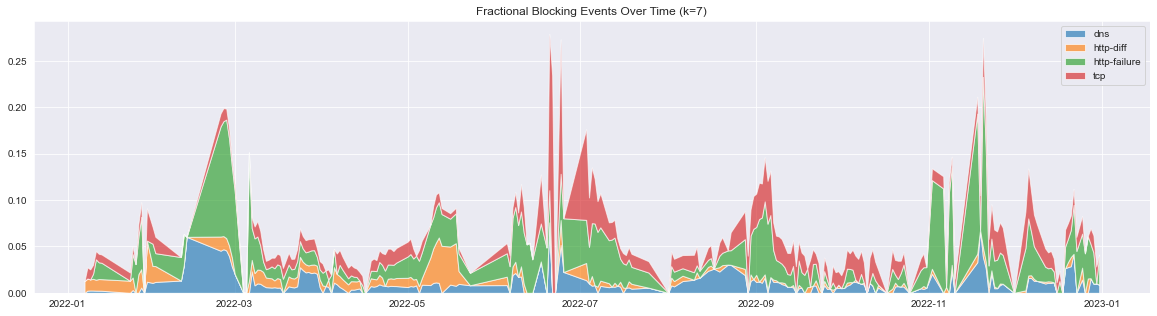

In [15]:
# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(total_events.index, frac_dns, frac_httpdiff, frac_httpfail, frac_tcp, labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events Over Time (k={k})')

In [16]:
# Extract known blocking methods
web_maybe_blocked = web_connectivity.loc[(web_connectivity['blocking'] != 'False') & (~web_connectivity['blocking'].isnull())]
web_maybe_blocked = web_maybe_blocked.sort_values(by=["input", "date"])
wmbi = web_maybe_blocked.set_index(['input', web_maybe_blocked.index])
wmbi

probe_asn control_failure  x_null_null_flags  \
input          date                                                      
0.1/dns-query  2022-02-24   AS30969             NaN                NaN   
               2022-11-02   AS30969             NaN                NaN   
0.3/dns-query  2022-09-09   AS37204             NaN                NaN   
               2022-11-02   AS30969             NaN                NaN   
               2022-11-23   AS37204             NaN                NaN   
...                             ...             ...                ...   
zoomshare.com/ 2022-11-02   AS30969             NaN                NaN   
zwnews.com/    2022-08-06   AS30969             NaN                NaN   
zzn.com/       2022-09-09   AS37204             NaN                NaN   
               2022-09-09   AS37204             NaN                NaN   
               2022-09-09   AS37204             NaN                NaN   

                          status_code_match title_match      blocking  \
input          date                                                     
0.1/dns-query  2022-02-24               NaN         NaN           dns   
               2022-11-02               NaN         NaN           dns   
0.3/dns-query  2022-09-09               NaN         NaN  http-failure   
               2022-11-02               NaN         NaN           dns   
               2022-11-23               NaN         NaN  http-failure   
...                                     ...         ...           ...   
zoomshare.com/ 2022-11-02               NaN         NaN  http-failure   
zwnews.com/    2022-08-06               NaN         NaN           dns   
zzn.com/       2022-09-09               NaN         NaN  http-failure   
               2022-09-09              True         NaN        tcp_ip   
               2022-09-09               NaN         NaN  http-failure   

                          resolver_asn accessible headers_match  \
input          date                                               
0.1/dns-query  2022-02-24          NaN      False           NaN   
               2022-11-02          NaN      False           NaN   
0.3/dns-query  2022-09-09      AS37204      False           NaN   
               2022-11-02          NaN      False           NaN   
               2022-11-23      AS37204      False           NaN   
...                                ...        ...           ...   
zoomshare.com/ 2022-11-02          NaN      False           NaN   
zwnews.com/    2022-08-06       AS3356      False           NaN   
zzn.com/       2022-09-09      AS37204      False           NaN   
               2022-09-09      AS37204      False          True   
               2022-09-09      AS37204      False           NaN   

                           body_proportion dns_experiment_failure  \
input          date                                                 
0.1/dns-query  2022-02-24              NaN                    NaN   
               2022-11-02              NaN                    NaN   
0.3/dns-query  2022-09-09              0.0                    NaN   
               2022-11-02              NaN                    NaN   
               2022-11-23              0.0                    NaN   
...                                    ...                    ...   
zoomshare.com/ 2022-11-02              NaN                    NaN   
zwnews.com/    2022-08-06              0.0     dns_nxdomain_error   
zzn.com/       2022-09-09              0.0                    NaN   
               2022-09-09              1.0                    NaN   
               2022-09-09              0.0                    NaN   

                           x_dns_flags  http_experiment_failure  \
input          date                                               
0.1/dns-query  2022-02-24          NaN  response_never_received   
               2022-11-02          NaN  response_never_received   
0.3/dns-query  2022-09-09          NaN    generic_timeout_error   
        

In [17]:
# Find sites with largest number of blocking events
topw = wmbi.groupby(level=0).size().sort_values(ascending=False)
topw

input
co.zw/                                401
org.zw/                               140
fadzayi4mp.com/                        91
gaytoday.com/                          83
gov.zw/                                80
                                     ... 
globalr2p.org/                          1
schwarzreport.org/                      1
gnome.org/check_network_status.txt      1
sayhichat.com/                          1
knapsackforhope.org/                    1
Length: 1467, dtype: int64

In [18]:
# Get data from the top blocking events
wmbi.loc[topw[topw > 10].index]

probe_asn control_failure  x_null_null_flags  \
input       date                                                      
co.zw/      2022-01-03   AS37204             NaN                NaN   
            2022-01-03   AS37204             NaN                NaN   
            2022-01-03   AS37204             NaN                NaN   
            2022-01-03   AS37204             NaN                NaN   
            2022-01-03   AS37204             NaN                NaN   
...                          ...             ...                ...   
geti2p.net/ 2022-07-06   AS37123             NaN                NaN   
            2022-07-18   AS37204             NaN                NaN   
            2022-09-01   AS37204             NaN                NaN   
            2022-09-11   AS37204             NaN                NaN   
            2022-11-02   AS30969             NaN                NaN   

                       status_code_match title_match      blocking  \
input       date                                                     
co.zw/      2022-01-03               NaN         NaN        tcp_ip   
            2022-01-03               NaN         NaN        tcp_ip   
            2022-01-03               NaN         NaN        tcp_ip   
            2022-01-03               NaN         NaN  http-failure   
            2022-01-03               NaN         NaN        tcp_ip   
...                                  ...         ...           ...   
geti2p.net/ 2022-07-06               NaN         NaN  http-failure   
            2022-07-18               NaN         NaN  http-failure   
            2022-09-01               NaN         NaN  http-failure   
            2022-09-11               NaN         NaN  http-failure   
            2022-11-02               NaN         NaN  http-failure   

                       resolver_asn accessible headers_match  body_proportion  \
input       date                                                                
co.zw/      2022-01-03      AS37204      False           NaN              0.0   
            2022-01-03      AS37204      False           NaN              0.0   
            2022-01-03      AS37204      False           NaN              0.0   
            2022-01-03      AS37204      False           NaN              0.0   
            2022-01-03      AS37204      False           NaN              0.0   
...                             ...        ...           ...              ...   
geti2p.net/ 2022-07-06          NaN      False           NaN              NaN   
            2022-07-18      AS37204      False           NaN              0.0   
            2022-09-01      AS37204      False           NaN              0.0   
            2022-09-11      AS37204      False           NaN              0.0   
            2022-11-02          NaN      False           NaN              NaN   

                       dns_experiment_failure  x_dns_flags  \
input       date                                             
co.zw/      2022-01-03                    NaN          NaN   
            2022-01-03                    NaN          NaN   
            2022-01-03                    NaN          NaN   
            2022-01-03                    NaN          NaN   
            2022-01-03                    NaN          NaN   
...                                       ...          ...   
geti2p.net/ 2022-07-06                    NaN          NaN   
            2022-07-18                    NaN          NaN   
            2022-09-01                    NaN          NaN   
            2022-09-11                    NaN          NaN   
            2022-11-02                    NaN          NaN   

                                                  http_experiment_failure  \
input       date                                                            
co.zw/      2022-01-03                                 connection_refused   
            2022-01-03                              generic_timeout_error   
            2022-01

In [19]:
sel = wmbi.loc[topw[topw > 10].index].loc[topw.index[10]]
ma = sel['blocking'] == 'dns'
sel[ma]

,probe_asn,control_failure,x_null_null_flags,status_code_match,title_match,blocking,resolver_asn,accessible,headers_match,body_proportion,dns_experiment_failure,x_dns_flags,http_experiment_failure,body_length_match,dns_consistency,x_blocking_flags
date,,,,,,,,,,,,,,,,
2022-01-31,AS328088,NaN,NaN,True,False,dns,AS30844,False,False,0.103849,NaN,NaN,NaN,False,inconsistent,NaN
2022-02-24,AS30969,NaN,NaN,True,False,dns,NaN,False,False,0.106215,NaN,NaN,NaN,False,inconsistent,NaN
2022-03-08,AS37204,NaN,NaN,True,False,dns,AS37204,False,False,0.104094,NaN,NaN,NaN,False,inconsistent,NaN
2022-03-28,AS30844,NaN,NaN,True,False,dns,AS30844,False,False,0.106624,NaN,NaN,NaN,False,inconsistent,NaN
2022-04-13,AS30844,NaN,NaN,True,False,dns,AS30844,False,False,0.105382,NaN,NaN,NaN,False,inconsistent,NaN
2022-04-21,AS30844,NaN,NaN,True,False,dns,AS30844,False,False,0.079551,NaN,NaN,NaN,False,inconsistent,NaN
2022-05-01,AS30969,NaN,NaN,True,False,dns,AS30844,False,False,0.078498,NaN,NaN,NaN,False,inconsistent,NaN
2022-05-02,AS30969,NaN,NaN,True,False,dns,AS30844,False,False,0.079789,NaN,NaN,NaN,False,inconsistent,NaN
2022-11-02,AS30969,NaN,NaN,True,NaN,dns,NaN,False,False,0.234555,NaN,NaN,NaN,False,inconsistent,NaN


In [20]:
web_connectivity.loc[web_connectivity['input'] == topw.index[0]]

,probe_asn,control_failure,x_null_null_flags,status_code_match,title_match,blocking,resolver_asn,accessible,headers_match,input,body_proportion,dns_experiment_failure,x_dns_flags,http_experiment_failure,body_length_match,dns_consistency,x_blocking_flags
date,,,,,,,,,,,,,,,,,
2022-01-01,AS37204,NaN,NaN,True,True,False,AS37204,True,False,co.zw/,1.000000,NaN,NaN,eof_error,True,consistent,NaN
2022-01-01,AS37204,NaN,NaN,True,NaN,False,AS37204,True,True,co.zw/,0.000000,NaN,NaN,NaN,NaN,consistent,NaN
2022-01-01,AS37204,NaN,NaN,True,NaN,False,AS37204,True,True,co.zw/,0.000000,NaN,NaN,NaN,NaN,consistent,NaN
2022-01-01,AS37204,NaN,NaN,True,True,False,AS37204,True,False,co.zw/,1.000000,NaN,NaN,NaN,True,consistent,NaN
2022-01-01,AS37204,NaN,NaN,True,True,False,AS37204,True,False,co.zw/,1.000000,NaN,NaN,NaN,True,consistent,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS37204,NaN,NaN,True,NaN,False,AS37204,True,True,co.zw/,0.000000,NaN,NaN,NaN,NaN,consistent,NaN
2022-12-31,AS37204,NaN,NaN,False,NaN,False,AS37204,True,False,co.zw/,0.000201,NaN,NaN,NaN,False,consistent,NaN
2022-12-31,AS37204,NaN,NaN,NaN,NaN,NaN,AS37204,NaN,NaN,co.zw/,0.000000,NaN,NaN,ssl_invalid_hostname,NaN,consistent,NaN


In [21]:
# Group all events by input calculate totals
dns_grouped = dns_events.groupby('input').size() # sort_values(ascending=False)
httpdiff_grouped = httpdiff_events.groupby('input').size()
httpfail_grouped = httpfail_events.groupby('input').size()
tcp_grouped = tcp_events.groupby('input').size()
totals_grouped = web_connectivity.groupby('input').size()

In [22]:
noblock_events = web_connectivity[(web_connectivity['blocking'] == 'False') | (web_connectivity['blocking'].isnull())]
noblock_grouped = noblock_events.groupby('input').size()

In [23]:
# Calculate fraction of events blocked per input
frac_dns_grouped = (dns_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpdiff_grouped = (httpdiff_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpfail_grouped = (httpfail_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_tcp_grouped = (tcp_grouped / totals_grouped).dropna().sort_values(ascending=False)

In [24]:
# Get all events grouped by the type of blocking event
all_grouped = pd.DataFrame({'dns': frac_dns_grouped, 'httpdiff': frac_httpdiff_grouped, 'httpfail': frac_httpfail_grouped, 'tcp': frac_tcp_grouped}).fillna(0)
all_grouped

,dns,httpdiff,httpfail,tcp
input,,,,
0.1/dns-query,0.032787,0.000000,0.000000,0.000000
0.3/dns-query,0.014286,0.000000,0.028571,0.000000
0.39:9131/tor/server/authority,0.000000,0.010101,0.010101,0.111111
1.1/dns-query,0.032258,0.000000,0.016129,0.016129
1.3/dns-query,0.015385,0.000000,0.000000,0.000000
...,...,...,...,...
zoom.us/,0.000000,0.000000,0.049180,0.016393
zoom.us/zoom.ico,0.025641,0.000000,0.000000,0.025641
zoomshare.com/,0.017857,0.000000,0.017857,0.000000


In [25]:
# Extract the top N sites
nn = 100
top_n_idx = all_grouped.sum(axis=1).sort_values(ascending=False)[0:nn].index
top_n = all_grouped.loc[top_n_idx]
top_n

,dns,httpdiff,httpfail,tcp
input,,,,
frontlinedefenders.org/pt/case/case-history-paul-kasonkomona,0.000000,0.000000,1.000000,0.000000
postzambia.com/news.php,0.000000,0.000000,1.000000,0.000000
christiantoday.com/article/rwandan.refugees.hide.in.church.after.violence.erupts.in.zambia/84926.htm,1.000000,0.000000,0.000000,0.000000
postzambia.com/,0.000000,0.000000,1.000000,0.000000
blackplanet.com/,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...
jesussaves.cc/,0.000000,0.163636,0.054545,0.018182
dcemail.com/,0.000000,0.000000,0.000000,0.235294
cidh.org/,0.012987,0.000000,0.051948,0.168831


In [26]:
# Calculate cumulative values
c_top_n = top_n.cumsum(axis=1)

Text(0.5, 0, 'Fraction of events')

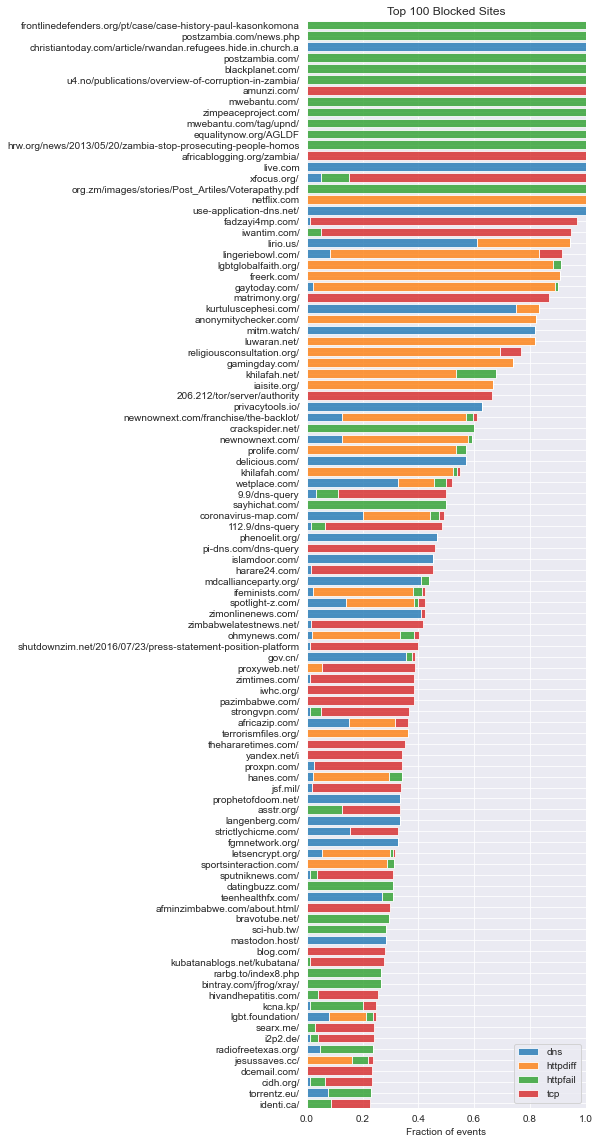

In [27]:
# Plot 
plt.rcParams['figure.figsize'] = [5, 20]
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['dns'].iloc[::-1], label='dns', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpdiff'].iloc[::-1], left=c_top_n.iloc[::-1,0], label='httpdiff', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpfail'].iloc[::-1], left=c_top_n.iloc[::-1,1], label='httpfail', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['tcp'].iloc[::-1], left=c_top_n.iloc[::-1,2], label='tcp', alpha=0.8)
plt.margins(y=0)
plt.legend()
plt.grid()
plt.title(f'Top {nn} Blocked Sites')
plt.xlabel('Fraction of events')